In [1]:
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import joblib
import mahotas
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.25
seed      = 9
fixed_size       = tuple((768, 768))
train_path = "dataset/train"
test_path  = "dataset/test"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
scoring    = "accuracy"
bins             = 5
num_classes = 5

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (15000, 145)
[STATUS] labels shape: (15000,)
[STATUS] training started...


In [2]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (11250, 145)
Test data   : (3750, 145)
Train labels: (11250,)
Test labels : (3750,)


LR: 0.927733 (0.007134)
LDA: 0.933600 (0.005364)
KNN: 0.987200 (0.002673)
CART: 0.983467 (0.002953)
RF: 0.994044 (0.001641)
NB: 0.704178 (0.010636)
SVM: 0.931022 (0.007001)


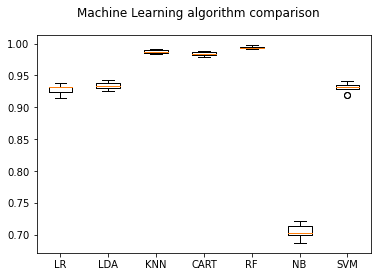

In [3]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [4]:
#-----------------------------------
# TESTING OUR MODEL
#-----------------------------------

# to visualize results
import matplotlib.pyplot as plt
import pandas as pd

#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
clf = GaussianNB()

# Train the model using the training sets
clf.fit(trainDataGlobal, trainLabelsGlobal)


print ("Accuracy on training set:")
print (clf.score(trainDataGlobal, trainLabelsGlobal))

print ("Accuracy on testing set:")
print (clf.score(testDataGlobal, testLabelsGlobal))

#predictions = clf.predict(rescaledY)
predictions = clf.predict(testDataGlobal)
print ("Display Summary:")
#display_summary(testDataGlobal,predictions)

cm1 = confusion_matrix(testLabelsGlobal, predictions)

print(cm1)
print(classification_report(testLabelsGlobal,predictions))


Accuracy on training set:
0.7060444444444445
Accuracy on testing set:
0.7157333333333333
Display Summary:
[[ 194   16  985]
 [  25 1225   15]
 [  23    2 1265]]
              precision    recall  f1-score   support

           0       0.80      0.16      0.27      1195
           1       0.99      0.97      0.98      1265
           2       0.56      0.98      0.71      1290

    accuracy                           0.72      3750
   macro avg       0.78      0.70      0.65      3750
weighted avg       0.78      0.72      0.66      3750



In [5]:
TruePositive = np.diag(cm1)
TruePositive

array([ 194, 1225, 1265], dtype=int64)

In [6]:
FalsePositive = [] 
i=1
for i in range(num_classes): 
    FalsePositive.append(sum(cm1[:,i]) - cm1[i,i]) 
FalsePositive 

IndexError: index 3 is out of bounds for axis 1 with size 3

In [7]:
FalseNegative = [] 

for i in range(num_classes):
    FalseNegative.append(sum(cm1[i,:]) - cm1[i,i])
FalseNegative

IndexError: index 3 is out of bounds for axis 0 with size 3

In [11]:
TrueNegative = []
i=1
for i in range(num_classes):
    temp = np.delete(cm1, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))
TrueNegative

[29, 33, 30, 32, 33]

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(trainDataGlobal, trainLabelsGlobal)

predictions = clf.predict(testDataGlobal)

cm1 = confusion_matrix(testLabelsGlobal, predictions)

print(cm1)
print(classification_report(testLabelsGlobal,predictions))


[[1174    1   20]
 [   0 1265    0]
 [  17    0 1273]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1195
           1       1.00      1.00      1.00      1265
           2       0.98      0.99      0.99      1290

    accuracy                           0.99      3750
   macro avg       0.99      0.99      0.99      3750
weighted avg       0.99      0.99      0.99      3750



In [9]:
predictions

array([1, 1, 2, ..., 1, 2, 2], dtype=int64)

In [10]:
y_pred_proba = clf.predict_proba(testDataGlobal)

In [15]:
y_pred_proba

array([[0.8, 0.2, 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.8, 0. , 0.2],
       [1. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. ],
       [0.6, 0.4, 0. , 0. , 0. ],
       [0.2, 0.8, 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0.2, 0. , 0.8],
       [0. , 0. , 0.4, 0. , 0.6],
       [0.4, 0.6, 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [0.2, 0.8, 0. , 0. , 0. ],
       [0. , 0. , 0.4, 0. , 0.6],
       [0.4, 0.6, 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [0.2, 0.8, 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0.6, 0. , 0.4],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0.6, 0. , 0.4],
       [0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [1. , 0

In [11]:

roc_auc_score(testLabelsGlobal,y_pred_proba,multi_class="ovr")

0.9989693397944666

In [12]:
tpr,fpr


NameError: name 'tpr' is not defined

In [13]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

TypeError: float() argument must be a string or a number, not 'dict'

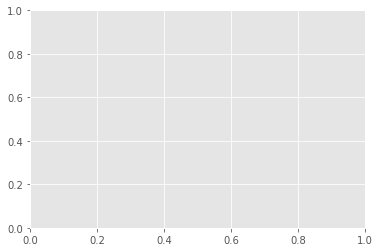

In [28]:
plot_roc_curve(fpr, tpr)

In [24]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_multilabel_classification
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
X = np.array(global_features)
y = np.array(global_labels)
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=seed)
                                                                                          

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Automatically created module for IPython interactive environment
